# Differential analysis of programs, 1: odd numbers
In this Jupyter notebook, I'll be using the `py_toy_vms` library to perform differential analysis on computer programs--by which is roughly meant analyzing the difference in program states.

This is intended as an introduction and to begin explore concepts in established differential computing as well as work through some of my own. In later parts, I intend to cover topics such as differential algorithms, harmonic analysis, automatic differentiation, stochastic differential equations, and others.

I do not intend to present myself as an authority on this subject. For those who care to read, consider this an opportunity to learning with rather than from. 

In [145]:
# import AntipaterTheMini (a small von Neumann vm) from py_toy_vms
from py_toy_vms import AntipaterTheMini
import numpy as np
from typing import Optional
import seaborn as sns
import scipy
import statsmodels.api as sm
import matplotlib.pyplot as plt
import sympy as sp
# plt.rcParams['text.usetex'] = True

## Counting over odd numbers
We'll start with a very simple program that counts up the odd numbers from 1.

In [146]:
program = """
SET 1 1 // start at 1
SET 2 2 // increase the value by 2

#LOOP
ADD 1 2 1 // store R1 + R2 in R1
JUMP #LOOP
"""

We'll run this program for 20 ticks to show what it does.

<Axes: title={'center': 'Value of R1 per tick'}, xlabel='# of ticks', ylabel='Value in R1'>

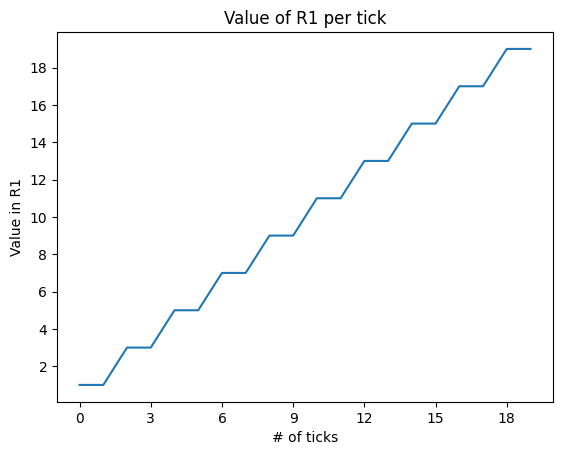

In [147]:
from matplotlib.ticker import MaxNLocator

vm = AntipaterTheMini()
vm.load_asm(program, 20)
vm.set_pc(20)

for i in range(0, 20):
    vm.tick()
    
ax = sns.lineplot(data=vm.get_states()[:,1]) # we'll take a look at R1 for now
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title("Value of R1 per tick")
ax.set_xlabel("# of ticks")
ax.set_ylabel("Value in R1")
ax

The above plots the value of the program at register index one, `R1`, with respect to the number of ticks. We are going to formalize the program as $\mathcal{Q}$ and the ticks as $t \in T$. The complete state of the program $\mathcal{Q}$ at a number of ticks $t_{n}$ from the introduction of an initial condition $\alpha$ is $\mathcal{Q}(t_{n}|\alpha)$. The value of a given address $i$ is $\mathcal{Q}_{i}(t_{n}|\alpha)$.

Let's take a look at all of the states.

In [148]:
vm.get_states()

array([[        21,          1,  917791799, ..., 3914420729, 3844071008,
        3393728396],
       [        22,          1,          2, ..., 3914420729, 3844071008,
        3393728396],
       [        23,          3,          2, ..., 3914420729, 3844071008,
        3393728396],
       ...,
       [        22,         17,          2, ..., 3914420729, 3844071008,
        3393728396],
       [        23,         19,          2, ..., 3914420729, 3844071008,
        3393728396],
       [        22,         19,          2, ..., 3914420729, 3844071008,
        3393728396]])

## Computing the differential

Let's do a discrete differential analysis. We'll compute the difference respect to time $t$ given an initial state $\alpha$ by simply computing the difference in register values $\Delta\mathcal{Q}(t|\alpha) = \mathcal{Q}(t_{n}|\alpha)-\mathcal{Q}(t_{n-1}|\alpha)$.

In [149]:
def dfq_t_given_alpha(*, 
    vm : Optional[AntipaterTheMini] = None, 
    states : Optional[np.ndarray] = None
):
    
    if vm is None and states is None:
        raise Exception("Must specify VM or states.")
    
    states = states if states is not None else vm.get_states()
    d1 = []
    for i in range(1, len(states)):
        d1.append(
            np.subtract(states[i], states[i-1])
        )
    return np.asarray(d1)

In [150]:
dfq_t_given_alpha(vm=vm)

array([[         1,          0, -917791797, ...,          0,          0,
                 0],
       [         1,          2,          0, ...,          0,          0,
                 0],
       [        -1,          0,          0, ...,          0,          0,
                 0],
       ...,
       [        -1,          0,          0, ...,          0,          0,
                 0],
       [         1,          2,          0, ...,          0,          0,
                 0],
       [        -1,          0,          0, ...,          0,          0,
                 0]])

Let's look at the difference in the value of `R1` with respect to time.

<Axes: title={'center': '$\\Delta \\mathcal{Q}_{r1}(t|\\alpha)$'}, xlabel='# of ticks, $t_{n}-1$', ylabel='$\\Delta \\mathcal{Q}_{r1}$'>

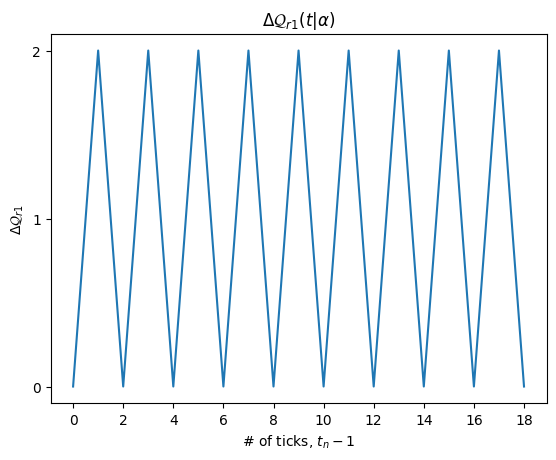

In [151]:
diff = dfq_t_given_alpha(states=vm.get_states()[:,1])
ax = sns.lineplot(diff)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"$\Delta \mathcal{Q}_{r1}(t|\alpha)$")
ax.set_xlabel("# of ticks, $t_{n}-1$")
ax.set_ylabel(r"$\Delta \mathcal{Q}_{r1}$")
ax

Despite still analyzing this program using a discrete differential, I plot the above using a continuous lineplot. This is intended to suggest the continuous form of the differential, i.e., the derivative, can be thought of as a periodic function.

Let's look at the second order differential. Because this is a periodic function, the second order differntial will also be.

<Axes: title={'center': '$\\Delta^2 \\mathcal{Q}_{r1}(t|\\alpha)$'}, xlabel='# of ticks, $t_{n}-2$', ylabel='$\\Delta^2 \\mathcal{Q}_{r1}$'>

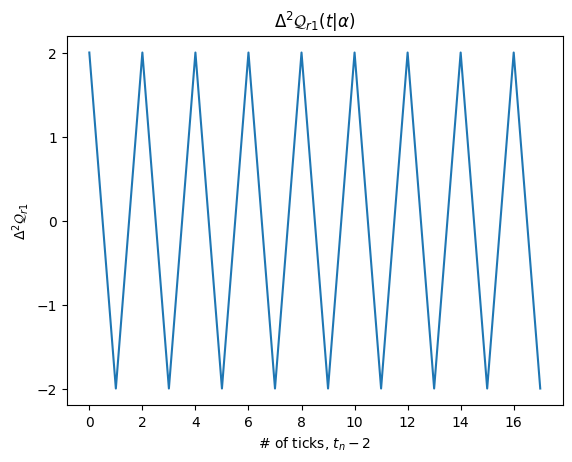

In [152]:
diff_2 = dfq_t_given_alpha(states=diff)
ax = sns.lineplot(diff_2)
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"$\Delta^2 \mathcal{Q}_{r1}(t|\alpha)$")
ax.set_xlabel("# of ticks, $t_{n}-2$")
ax.set_ylabel(r"$\Delta^2 \mathcal{Q}_{r1}$")
ax

This is important because it underscores something that we'll run into a lot. A program  is often not going to have a well-defined limit--even with respect to a single register. This doesn't preclude differential analysis. But, we are going to need to work with periodic functions--the big two being the $sin$ and $cos$.

## Approximating with the $cos$

Let's approximate the continuous form of first order differential with the $cos$. We will say that $\frac{d\mathcal{Q}_{r1}}{dt} \approx cos((t - 1)*\pi) + 1$.

<Axes: title={'center': 'Fitting $cos$ to $\\Delta \\mathcal{Q}_{r1}$'}, xlabel='# of ticks, $t_{n}-1$', ylabel='$\\Delta \\mathcal{Q}_{r1}$'>

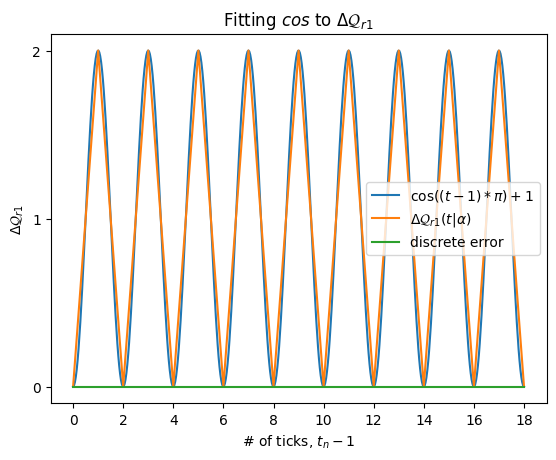

In [153]:
t = sp.symbols('t')

f = sp.cos((t - 1) * sp.pi) + 1

f_numeric = sp.lambdify(t, f, modules='numpy')

x = np.linspace(0, 18, 500)

y = f_numeric(x)

# Plot the function
fig, ax = plt.subplots()
# Plot the SymPy-based function
ax.plot(x, y, label=r"$\cos((t - 1)*\pi) + 1$")
ax.plot(range(0, 19), diff, label=r"$\Delta \mathcal{Q}_{r1}(t|\alpha)$")
ax.plot(range(0, 19), [diff[i] - f_numeric(i) for i in range(0, 19)], label="discrete error")
ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Fitting $cos$ to $\Delta \mathcal{Q}_{r1}$")
ax.set_xlabel("# of ticks, $t_{n}-1$")
ax.set_ylabel(r"$\Delta \mathcal{Q}_{r1}$")
ax.legend()
ax

Cool, now we can compute the value of `R1` at any tick $t_{n}$ as $\int_{0}^{n}(\cos((t - 1)*\pi) + 1) dt$ = $\frac{1}{\pi}sin((t-1) * \pi) + t + 1$

<Axes: title={'center': 'Fitting $\\int cos$ to $\\mathcal{Q}_{r1}$'}, xlabel='# of ticks, $t_{n}-1$', ylabel='$\\mathcal{Q}_{r1}$'>

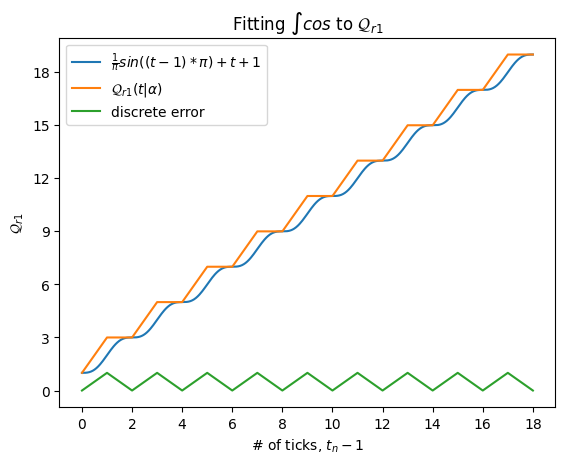

In [154]:
t = sp.symbols('t')

f = (1/sp.pi) * sp.sin((t - 1) * sp.pi) + t + 1

f_numeric = sp.lambdify(t, f, modules='numpy')

x = np.linspace(0, 18, 500)

y = f_numeric(x)

fig, ax = plt.subplots()

states = vm.get_states()[1:,1]
ax.plot(x, y, label=r"$\frac{1}{\pi}sin((t-1) * \pi) + t + 1$")
ax.plot(range(0, 19), states, label=r"$\mathcal{Q}_{r1}(t|\alpha)$")
ax.plot(range(0, 19), [states[i] - f_numeric(i) for i in range(0, 19)], label="discrete error")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Fitting $\int cos$ to $\mathcal{Q}_{r1}$")
ax.set_xlabel("# of ticks, $t_{n}-1$")
ax.set_ylabel(r"$\mathcal{Q}_{r1}$")
ax.legend()
ax

This method of approximation doesn't quite work. We have significant loss where $\Delta\mathcal{Q}(t|\alpha) = 0$. However, where $\Delta\mathcal{Q}(t|\alpha) \neq 0$, we fit our program appropriately. 

I intend to discuss the above more carefully in future entries. For now, I feel it is important to make three points:
1. The primary reason for this loss is that the continuous interpretation of our program does not have a finite derivative; it is not Lipschitz-continuous. And, in fact, only linear programs can satisfy this criterion. 
2. We can do better by approximating using sums of sinusodial functions and the Fourier Transform will help us do this. 
3. We can also analytically do better by imaging a different sort of time.

## `R1` time

To this point, we've considered our program as a function in terms of ticks. However, our program could also take a different view of time which is only concerned with the changes in R1. 

Under this interpretation, we would of course approximate as $\mathcal{Q}_{r1}(t_{r1} \in T | \alpha) \approx 2t_{r1} + 1$.

<Axes: title={'center': 'Fitting $\\beta t$ to $\\mathcal{Q}_{r1}$'}, xlabel='# of changes, $t_{r1_{n}}-1$', ylabel='$\\mathcal{Q}_{r1}$'>

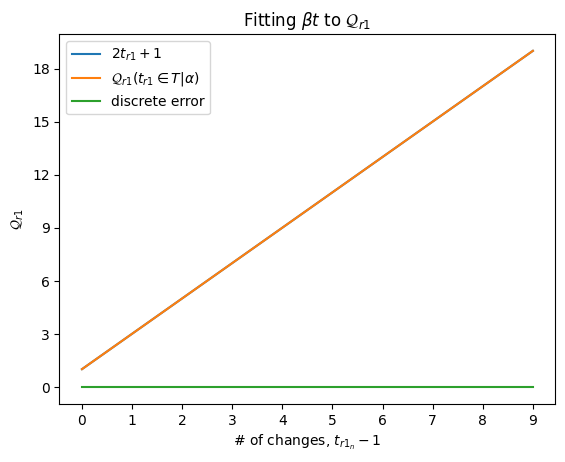

In [155]:
t = sp.symbols('t')

f = 2*t + 1

f_numeric = sp.lambdify(t, f, modules='numpy')

x = np.linspace(0, 9, 500)

y = f_numeric(x)

fig, ax = plt.subplots()

states = vm.get_states()[1:,1]
dropped_states = [
    states[i] 
    for i in range(0, len(states)) 
    if i < 1 or (states[i] - states[i - 1]) != 0
]
ax.plot(x, y, label=r"$2t_{r1} + 1$")
ax.plot(range(0, len(dropped_states)), dropped_states, label=r"$\mathcal{Q}_{r1}(t_{r1} \in T | \alpha)$")
ax.plot(range(0, len(dropped_states)), [dropped_states[i] - f_numeric(i) for i in range(0, len(dropped_states))], label="discrete error")

ax.xaxis.set_major_locator(MaxNLocator(integer=True))
ax.yaxis.set_major_locator(MaxNLocator(integer=True))
ax.set_title(r"Fitting $\beta t$ to $\mathcal{Q}_{r1}$")
ax.set_xlabel("# of changes, $t_{r1_{n}}-1$")
ax.set_ylabel(r"$\mathcal{Q}_{r1}$")
ax.legend()
ax

Just looking at `R1`, we might realize that we don't in fact 'need' whatever other logic exists in our program. I intend to approach this concept of 'need' and time in more formality in futue in entries. However, I hope the intrigue of this analytical approach has become apparent.